# Table of Contents
- [Objective](#objective)
- [Image preparation](#img_prep)
    - [Data (csv) preparation - preprocessing and wrangling](#data_prep)
    - [Image processing using Data Generators](#image_process)
- [Build and Train CNN](#build_and_train_cnn)
- [Predict using model](#predict_cnn)

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools
import os
import shutil
import random
from random import randint
import glob

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# check if tensorflow is identifying gpu, uncomment if using gpu
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("Num GPUs Available: " , len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
PROJECT_DIR = '/Users/mherarabian/Desktop/ml_projects/face-mask-detection/'
# original working directory
owd = os.getcwd()
#owd = WORKING_DIR
os.chdir(owd)

<a id='objective'></a> 
# Objective
Build and train a **Convolutional Neural Network** using Tensorflow's Keras API that can classify images of people by detecting face masks. The goal is to train a NN model that can take an image and identify if individual(s) in the image are not wearing face masks, or are wearing one incorrectly. 

The model should classify images as either "mask" (1)  or "no-mask" (0). 

<a id='img_prep'></a> 
# Image Preparation
We will go thru all the **image preparation and processing** steps needed to train our **convolutional neural network**. 

First thing we need to do is to get and prepare out data set for which we will be training our model.
The data set we’ll use is from the Kaggle [Face Mask Detection Dataset](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset).

<a id='data_prep'></a> 
## Data preparation (including preprocessing, data wrangling, and cleaning)

Read more about [data wrangling](https://mc.ai/data-cleaning-vs-data-wrangling-2/), [data cleaning](https://theappsolutions.com/blog/development/data-wrangling-guide-to-data-preparation/) and [data preprocessing](https://www.infoq.com/articles/ml-data-processing/#:~:text=Data%20Preprocessing%3A%20Preparation%20of%20data,it%20from%20a%20data%20source.&text=This%20step%20is%20done%20before,data%20analysis%20and%20model%20building).<br><br>In short:

- **data preprocessing** is the preparation of data directly after accessing it from a data source. This can involve initial transformations, aggregations and data cleansing. This step is done before the interactive analysis of data begins. It is executed once.


- **data wrangling** is about transforming the data into the right format. This is the preparation of data during the interactive data analysis and model building. *Data cleaning* is finding and removing incorrect and inaccurate records from a recordset or a data source and modifying or deleting this data. Note that data cleansing and feature engineering can occur at both data preprocessing and data wrangling stages.

<br>First let's organize our image data into **train**, **valid**, **test** directories. We have to do some stuff first...

Our raw data set contains 6,024 total images (in .png .jpg .jpeg formats) found under directory *data/medical_masks/images*. The first 1800 images are not labeled, and should be used for the **test set**. The remaining 4,224 can be used for **training** and **validation sets**.

For now, let us only use a small subset of this data to train faster. Lets work with a subset consisting of 1,000 images in training set, 200 in validation set, and 100 in our test set. Each of those sets are going to be split evenly amongst **mask** and **no-mask**.

Since the image files themselves aren't labeled in any way, let's start with loading the labels from the *data/train.csv* file, which contains the labels of our images (excluding first 1800 images reserved for test set). Each image has a unique identifier **name** (same as its filename) and a **classname**, which is one of the classes defined in *data/medical_masks/meta.json* (e.g. face_with_mask, face_no_mask, mask_surgical, mask_colorful, face_shield, etc).

### Load csv data

In [4]:
df = pd.read_csv('data/train.csv')

In the dataframe below, each sample has a: 

- **name** - these are the names of the images in our dataset.
- **x1, x2, y1, y2** - [bounding box](https://medium.com/anolytics/the-use-of-bounding-boxes-in-image-annotation-for-object-detection-6371711eabba) coordinates, we will ignore these.
- **classname** - one of 20 possible classes: hijab_niqab, mask_colorful, mask_surgical, face_no_mask, face_with_mask_incorrect, face_with_mask, face_other_covering, scarf_bandana, balaclava_ski_mask, face_shield, other, gas_mask, turban, helmet, sunglasses, eyeglasses, hair_net, hat, goggles, hood.

These are our *column labels*. Lets check a few samples (rows) in our dataframe.

In [5]:
# Check out a few rows of the dataframe
print(df.shape)
df.head()

(15412, 6)


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


### Drop columns we don't need
* include subset of columns of larger data frame

In [6]:
# drop columns we don't want
# axis=0 means along the rows and axis=1 along the columns.
df = df.drop(labels=['x1', 'x2', 'y1', 'y2'], axis=1)
print(df.shape)

(15412, 2)


### Filtering data (slicing)
* include a subset (slice) of rows from larger data frame

In [7]:
#interested_classnames = ['mask_colorful', 'mask_surgical', 'face_no_mask', 'face_with_mask_incorrect', 'face_with_mask', 'other', 'turban', 'helmet', 'sunglasses', 'eyeglasses', 'hair_net', 'hat', 'goggles', 'hood']
# Select only classnames that we are interested in
#df = df[df['classname'] == 'mask_colorful']


### Drop duplicates

In [8]:
# drop duplicates on specific column
df = df.drop_duplicates(subset=['name'])
print(df.shape)

(4326, 2)


### Missing data (NaNs and null values)

In [9]:
# Check for missing values
print(df['classname'].hasnans)

False


In [10]:
# Check for null values
print(sum(df['classname'].isnull()))

0


### Reset indices in dataframe

In [11]:
df = df.reset_index(drop=True)
df.head()

,name,classname
0,2756.png,face_with_mask
1,6098.jpg,face_no_mask
2,6427.png,face_with_mask_incorrect
3,4591.png,face_with_mask
4,5392.jpg,face_other_covering


**Get entry for image 1801**

In [12]:
df.loc[df['name'] == '1801.jpg']

,name,classname
3742,1801.jpg,face_no_mask


### Mutating data - change all classnames to mask or no-mask

In [13]:
# get classname Pandas Series as Python list
classnames = list(df['classname'])

In [14]:
# all possible classes categorized into mask or no-mask
MASK_CLASSES = ['mask_colorful', 'mask_surgical', 'face_with_mask']
NO_MASK_CLASSES = ['hijab_niqab', 'face_no_mask', 'face_with_mask_incorrect', 'face_other_covering', 'scarf_bandana', 'balaclava_ski_mask', 'face_shield', 'other', 'gas_mask', 'turban', 'helmet', 'sunglasses', 'eyeglasses', 'hair_net', 'hat', 'goggles', 'hood']

# takes in a list, and returns new list where each entry is either 'mask' or 'no-mask'
def mask_or_no_mask(classnames):
    binary_classnames = ['mask' if c in MASK_CLASSES else 'no-mask' for c in classnames]
    return binary_classnames            

In [15]:
# convert classnames into binary label: mask or no-mask
classnames = mask_or_no_mask(classnames)
print(type(classnames))
print(len(classnames))

<class 'list'>
4326


In [16]:
# add new list of labels to dataframe
df['label']= classnames
# drop the old classnames column
df = df.drop(labels=['classname'], axis=1)
# check out our dataframe
df.head()

,name,label
0,2756.png,mask
1,6098.jpg,no-mask
2,6427.png,no-mask
3,4591.png,mask
4,5392.jpg,no-mask


### Finally we can organize our image data into train, valid, test directories and begin preprocessing the images.

In [17]:
# filter dataframe to get names of images with masks and no masks into separate python lists
img_names_mask = list((df[df['label'] == 'mask'])['name'])
img_names_no_mask = list((df[df['label'] == 'no-mask'])['name'])
print(len(img_names_mask), len(img_names_no_mask))

2572 1754


### Shuffle image names

In [18]:
# shuffle all image names
img_names_mask = shuffle(img_names_mask)
img_names_no_mask = shuffle(img_names_no_mask)

In [19]:
len(img_names_mask)

2572

In [20]:
len(img_names_no_mask)

1754

In [21]:
# cd to project dir
os.chdir(owd)

### Make directories for training, validation, test data

In [22]:
os.chdir('data/medical_masks')

if os.path.isdir('train/mask') is False:
    os.makedirs('train/mask')
    os.makedirs('train/no-mask')
    os.makedirs('valid/mask')
    os.makedirs('valid/no-mask')
    os.makedirs('test/mask')
    os.makedirs('test/no-mask')
    
    
    
    # place 3226 images in training set ~75%
    
    
    # place 750 images in validation set ~17%

    
    # place 350 images in test set ~8%

### Split image data into these directories

In [23]:
# total 4326 images - 2572 mask, 1754 no-mask

try:
    # training set - add 1929 mask, 1315 no-mask - 75%
    for img_name in img_names_mask[0:1929]:
        shutil.move('images/' + img_name, 'train/mask')
    for img_name in img_names_no_mask[0:1315]:
        shutil.move('images/' + img_name, 'train/no-mask')


    # validation set - add 437 mask, 298 no-mask
    for img_name in img_names_mask[1929:2366]:
        shutil.move('images/' + img_name, 'valid/mask')

    for img_name in img_names_no_mask[1315:1613]:
        shutil.move('images/' + img_name, 'valid/no-mask')


    # test set - add 206 mask, 141 no-mask
    for img_name in img_names_mask[2366:]:
        shutil.move('images/' + img_name, 'test/no-mask')
    for img_name in img_names_no_mask[1613:]:
        shutil.move('images/' + img_name, 'test/no-mask')
except:
    pass    

# maybe catch FileNotFoundError, other exceptions?

In [24]:
os.chdir('../../')

In [25]:
os.getcwd()

'/home/marabian/Desktop/face-mask-detection'

## >> START HERE - DATA WAS PROCESSED BY PYTHON SCRIPT

<a id="image_process"></a>
## Image processing

In [26]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

### Put images into [Keras Data Generator](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) format
[More on Data Generators](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)
This will basically create batches of data from the directories where our datasets reside. These batches of data will be able to be passed to the Sequential model using the **fit** function.

Article on the popular image classifier CNN model [vgg16](https://neurohive.io/en/popular-networks/vgg16/).

We are storing the image data in a **Keras Sequence**, specifically a **DirectoryIterator**, using the ImageDataGenerator.flow_from_directory() function. This function generates/feeds batches of image data from the specified location on disk.

In [27]:
# preprocessing_function applies some type of preprocessing on the images, we are processing them
# in such a way that is equivalent to the way vgg16 does.
# Basically we're processing our images in the same format as which images that get pased to 
# vgg16 are processed

# flow from directory - passes in our image directory on disk, target_size is height and width we want
# our images to be resized to. Classes specify are datasets label

# shuffle=False because when we use our batches for inference, we want to look at the results in a confusion matrix
# so we need to access the unshuffled labels for our test set. we want our training and validation batches shuffed

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=32)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=32, shuffle=False)

Found 3244 images belonging to 2 classes.
Found 735 images belonging to 2 classes.
Found 347 images belonging to 2 classes.


In [28]:
assert train_batches.n == 3244
assert valid_batches.n == 735
assert test_batches.n == 347
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

### Grab a single batch of images and corresponding labels from our training batches
Since our batch size is 10, this should be 10 images along with 10 corresponing labels. Lets print some of these images using this function pulled directly from [Tensorflow's website](https://www.tensorflow.org/tutorials/images/classification#visualize_training_images).

In [29]:
imgs, labels = next(train_batches)

In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

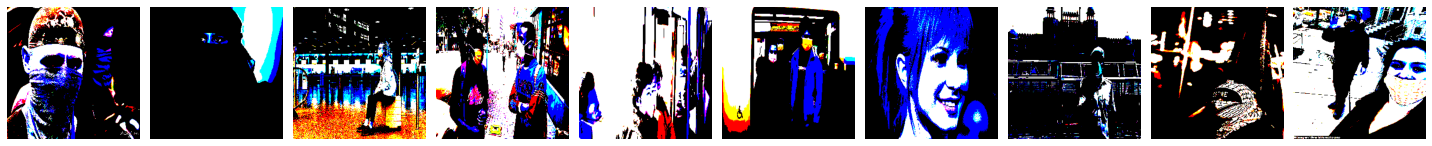

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [31]:
plotImages(imgs)
print(labels)

As seen above, the labels are [one-hot encoded](https://deeplizard.com/learn/video/v_4KWmkwmsU) vectors that represent either mask or no-mask. A [1, 0] represents **mask**, and a [0, 1] represents **no-mask**.

<a id='build_and_train_cnn'></a>
# Build and Train a Convolutional Neural Network

Our training data is stored in a DirectoryIterator, so we need to pass this to the **fit** function for training. With a recent update to Tensorflow, we are now required to pass in the **steps_per_epoch** param to the fit function whenever our training data is contained in an infinitely repeating dataset like with our DirectoryIterator data set. This repeatedly gives us batches whenever we call the built in python *next* function.

**steps_per_epoch** - should be equal to the number of steps or number of batches of samples to yield from our data set (training set) before declaring 1 epoch finished during the training process. Typically this is the **(number of samples in our training set)/batch_size**. Think of this as how many batches (of size 10) to pull from our data set (DirectoryIterator) to complete 1 epoch. This parameter is required when using a Keras sequence, like our DirectoryIterator.

If passing **validation data** we also need to also specify **validation_steps**, acts in same way as **steps_per_epoch** but in regard to validation set.

Whenever we call **model.predict()** for inference, now we need to specify **steps** parameter, which again is same as **steps_per_epoch** but when using it for predictions, it is the number of batches to yield from the dataset before declaring prediction round finished.

Lets create our CNN model!

In [32]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

**First layer is a Conv2D layer** - standard conv layer that accepts image data, will arbitrarily have 32 filters with a kernel_size of (3,3) which is a common choice for image data. This layer is followed by **relu** activation function, and padding='same' means our images will have 0-padding, so the dimensionality of our images isn't reduced after the **convolution** operations.<br>
input_shape is to implicitly create the input layer, this param tells the model the shape of the input data. Recall during image processing we specified the target_size param as (224,224). The 3 is the color channels (rgb format).

**Then followed is a Max pooling layer** - pool size is (2,2) and stride 2, this is going to cut our image dimensions in half.

**Followed another Conv layer** - filter 64 here. General rule is to increase functions as you go into later layers.

**Another Max pooling layer** - similar to before.

**Flatten** - flatten into 1-dimensional tensor before passing it to Dense layer

**Dense output layer** - 2 nodes, corresponding to mask, no-mask

**Followed by softmax activation function** - will give us probabilities for each corresponding output

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2097154   
Total params: 2,395,906
Trainable params: 2,395,906
Non-trainable params: 0
______________________________________________

In [34]:
# NOTE: can also use binary_crossentropy, and have 1 single output node from our model, and rather then using softmax
# following our output layer, we would use sigmoid
# These approachesa are pretty much equivalent, categorical_crossentropy and softmax is a common approach
# when you have more than 2 classes.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# NOTE: not specifying y, because when data is stored as 
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
102/102 - 582s - loss: 18.2859 - accuracy: 0.5715 - val_loss: 0.9672 - val_accuracy: 0.5646
Epoch 2/10
102/102 - 555s - loss: 0.3674 - accuracy: 0.8499 - val_loss: 0.9441 - val_accuracy: 0.5891
Epoch 3/10
102/102 - 559s - loss: 0.0943 - accuracy: 0.9821 - val_loss: 0.9852 - val_accuracy: 0.5946
Epoch 4/10
102/102 - 558s - loss: 0.0251 - accuracy: 0.9997 - val_loss: 1.1095 - val_accuracy: 0.6122
Epoch 5/10
102/102 - 557s - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.1903 - val_accuracy: 0.5973
Epoch 6/10
102/102 - 554s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3230 - val_accuracy: 0.6014
Epoch 7/10
102/102 - 555s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.3963 - val_accuracy: 0.5959
Epoch 8/10
102/102 - 548s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.5086 - val_accuracy: 0.6122
Epoch 9/10
102/102 - 551s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.5503 - val_accuracy: 0.5986
Epoch 10/10
102/102 - 545s - loss: 7.4263e-04 - accuracy: 1.0000 - val_loss: 1.63

### Save model

In [41]:
# Checks first to see if file exists already.
# If not, the model is saved to disk.
import os.path
if os.path.isfile('models/mask_detection_model.h5') is False:
    model.save('models/mask_detection_model.h5')

In [39]:
os.getcwd()

'/home/marabian/Desktop/face-mask-detection'

<a id='predict_cnn'></a>
# Predictions

In [49]:
print(len(train_batches))

23
